In [2]:
import tensorflow as tf

%env CUDA_VISIBLE_DEVICES=3

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=3


In [3]:
def conv_block(x, layout, filters=None, kernel_size=1,
               transpose=False, rate=0.1, activation=None, is_training=True):
    ci = 0
    try:
        iter(filters)
    except TypeError:
        filters = list([filters] * layout.count('c'))

    for s in layout:
        if s == 'c':
            if transpose:
                x = tf.expand_dims(x, -2)
                x = tf.layers.conv2d_transpose(x, filters[ci], (kernel_size,) + (1,),
                                               strides=(2, 1), padding='same')
                x = tf.squeeze(x, axis=-2)
            else:
                x = tf.layers.conv1d(x, filters[ci], kernel_size, strides=1,
                                     padding='same')
            ci += 1
        elif s == 'a':
            if activation is not None:
                x = getattr(tf.nn, activation)(x)
        elif s == 'p':
            x = tf.layers.max_pooling1d(x, pool_size=2, strides=2, padding='same')
        elif s == 'n':
            x = tf.layers.batch_normalization(x, training=is_training, momentum=0.9)
        elif s == 'd':
            x = tf.layers.dropout(x, rate=rate, training=is_training)
        else:
            raise KeyError('unknown letter {0}'.format(s))
    return x

def u_net(x, depth, filters, kernel_size, activation=None, is_training=True):
    conv_d = []

    conv = x
    print('input', conv.get_shape())

    for d in range(depth):
        conv = conv_block(conv, layout='caca', filters=filters * (2 ** d),
                          kernel_size=kernel_size, activation=activation,
                          is_training=is_training)
        print('conv_block_{0}'.format(d), conv.get_shape())
        conv_d.append(conv)
        conv = conv_block(conv, layout='pd', is_training=is_training)
        print('pool_{0}'.format(d), conv.get_shape())

    conv = conv_block(conv, layout='cacad', filters=filters * (2 ** depth),
                      kernel_size=kernel_size, activation=activation,
                      is_training=is_training)
    print('bottom_conv_block_{0}'.format(depth), conv.get_shape())

    up = conv

    for d in range(depth, 0, -1):
        up = conv_block(up, 'cad', filters=filters * (2 ** d),
                        activation=activation, kernel_size=kernel_size,
                        transpose=True, is_training=is_training)
        
        concat_shape = conv_d[d - 1].get_shape()
        up = tf.cond(tf.less(concat_shape[1], tf.shape(up)[1]),
                     true_fn=lambda: tf.slice(up, [0, 0, 0], [-1, concat_shape[1], -1]),
                     false_fn=lambda: up)

        print('up_{0}'.format(d - 1), up.get_shape())
        up = tf.concat([up, conv_d[d - 1]], axis=-1)
        print('concat_{0}'.format(d), up.get_shape())
        up = conv_block(up, 'cacad', filters=filters * (2 ** (d - 1)), 
                        kernel_size=kernel_size, activation=activation,
                        is_training=is_training)
        print('up_conv_block_{0}'.format(d), up.get_shape())

    return up

In [28]:
# learning_rate=0.001

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_in = tf.placeholder('float', shape=(None, 2000, 1), name='trace_in')
    trace_offset = tf.placeholder('float', shape=(None, 1), name='trace_offset')
    target = tf.placeholder('float', shape=(None, 2000, 1), name='target')
    balance = tf.placeholder('float', name='balance')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    with tf.variable_scope("attention_scope"):
        attention = u_net(trace_in, depth=3, filters=8, kernel_size=3,
                          activation='elu', is_training=is_training)
        attention = conv_block(attention, 'c', filters=1, kernel_size=3)
        attention = conv_block(attention, 'ca', filters=1, kernel_size=3,
                               activation='sigmoid')
        print('attention', attention.get_shape())

        attention_sum = tf.reduce_sum(attention, axis=1)

        print('attention_sum', attention_sum.get_shape())

        sigm_x = tf.fill(tf.shape(attention)[:2], 0.0)
        sigm_x = tf.add(sigm_x, -tf.range(0, tf.cast(tf.shape(attention)[1], 'float'), dtype='float'))

#         shift_in = tf.concat([attention_sum, trace_offset], axis=1)
#         print('shift_in', shift_in.get_shape())
#         shift_in = tf.layers.dense(shift_in, 16, activation=tf.nn.elu)
#         shift_out = tf.layers.dense(shift_in, 2, activation=tf.nn.relu)
    
#     sigm_x = tf.divide(tf.add(sigm_x, shift_out[:, :1]), 1 + shift_out[:, 1:2])
    sigm_x = tf.add(sigm_x, attention_sum)
    
    attention_sigmoid = tf.expand_dims(tf.sigmoid(sigm_x), -1)
    print('attention_sigmoid', attention_sigmoid.get_shape())
    
    with tf.variable_scope("lift_scope"):
        lift_trace = u_net(trace_in, depth=5, filters=16, kernel_size=7,
                          activation='elu', is_training=is_training)
        lift_trace = conv_block(lift_trace, 'c', filters=1, kernel_size=3)
    print('lift', lift_trace.get_shape())
    
    predict = (tf.multiply(trace_in, attention_sigmoid) +
               tf.multiply(lift_trace, 1 - attention_sigmoid))
    loss = (tf.losses.absolute_difference(target, predict,
#                                           weights=1-attention_sigmoid,
#                                           reduction=tf.losses.Reduction.MEAN
                                         ) +
            balance * tf.reduce_mean(1 - attention_sigmoid)
           )
    
    gr_loss = tf.losses.absolute_difference(target, predict,
                                            reduction=tf.losses.Reduction.SUM,
                                            weights=(1 - attention_sigmoid) / (1e-10 + tf.reduce_sum(1 - attention_sigmoid, axis=1, keepdims=True))
                                           )


    optimizer = tf.train.AdamOptimizer(learning_rate)
    lift_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='lift_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(loss, var_list=attention_vars)
        step_lift = optimizer.minimize(loss, var_list=lift_vars)
        step_gr_lift = optimizer.minimize(gr_loss, var_list=lift_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, './demo_attention_model_H.ckpt')

input (?, 2000, 1)
conv_block_0 (?, 2000, 8)
pool_0 (?, 1000, 8)
conv_block_1 (?, 1000, 16)
pool_1 (?, 500, 16)
conv_block_2 (?, 500, 32)
pool_2 (?, 250, 32)
bottom_conv_block_3 (?, 250, 64)
up_2 (?, 500, 64)
concat_3 (?, 500, 96)
up_conv_block_3 (?, 500, 32)
up_1 (?, 1000, 32)
concat_2 (?, 1000, 48)
up_conv_block_2 (?, 1000, 16)
up_0 (?, 2000, 16)
concat_1 (?, 2000, 24)
up_conv_block_1 (?, 2000, 8)
attention (?, 2000, 1)
attention_sum (?, 1)
attention_sigmoid (?, 2000, 1)
input (?, 2000, 1)
conv_block_0 (?, 2000, 16)
pool_0 (?, 1000, 16)
conv_block_1 (?, 1000, 32)
pool_1 (?, 500, 32)
conv_block_2 (?, 500, 64)
pool_2 (?, 250, 64)
conv_block_3 (?, 250, 128)
pool_3 (?, 125, 128)
conv_block_4 (?, 125, 256)
pool_4 (?, 63, 256)
bottom_conv_block_5 (?, 63, 512)
up_4 (?, ?, 512)
concat_5 (?, 125, 768)
up_conv_block_5 (?, 125, 256)
up_3 (?, 250, 256)
concat_4 (?, 250, 384)
up_conv_block_4 (?, 250, 128)
up_2 (?, 500, 128)
concat_3 (?, 500, 192)
up_conv_block_3 (?, 500, 64)
up_1 (?, 1000, 64)
co

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, KNNIndex, CustomIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)

path_raw = [
#             '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy',
            '/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy'
]
path_lift = [
#              '/notebooks/egor/noise_data/DN02B_SHOTS_LIFT1.sgy',
             '/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy'
]

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
# index = index.filter('offset', lambda x: x < 1500)
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
3370,35,473,1,/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy,1,/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy
3370,36,472,2,/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy,2,/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy
3370,79,471,3,/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy,3,/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy
3370,79,474,4,/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy,4,/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy
3370,127,470,5,/notebooks/egor/noise_dataset_2/D01_for_Lift.sgy,5,/notebooks/egor/noise_dataset_2/D02_Lift_SP.sgy


In [7]:
tindex = TraceIndex(index.create_subset(index.indices[:20]))
train_set = Dataset(tindex, SeismicBatch)
len(train_set)

19440

In [8]:
train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy',
                        tslice=np.arange(2000)))
train_pipeline = train_pipeline << train_set

In [143]:
from tqdm import tqdm
import matplotlib.pyplot as plt

loss_history = []
for _ in tqdm(range(1000)):
    batch = train_pipeline.next_batch(batch_size=64, drop_last=True,
                                      n_enochs=None, shuffle=True)
    x = np.expand_dims(np.vstack(batch.raw), -1)
    y = np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    res = sess.run([
                    loss, 
                    step_attention,
                    step_lift,
#                     gr_loss, 
#                     step_gr_lift
                   ],
                   feed_dict={trace_in: x, target: y, trace_offset: offset, 
                              is_training: True,
                              balance: 0.01,
                              learning_rate: 0.0001})
    loss_history.append(res[0])

100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]


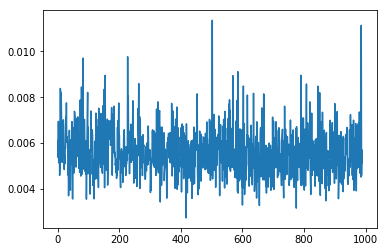

In [144]:
plt.plot(loss_history[10:])
plt.show()

In [40]:
i = 30
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1, shuffle=False)
             .load(components=('raw', 'lift'), fmt='segy',
                   tslice=np.arange(2000)))
    
    coef = 5
    x = coef*np.expand_dims(np.vstack(batch.raw), -1)
    y = coef*np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    res = sess.run([attention, predict, lift_trace, attention_sigmoid,
#                     shift_out
                   ],
                    feed_dict={trace_in: x,
#                                trace_offset: offset,
                               is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)

In [41]:
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
# shift_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

In [42]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 3))
# ax[0].plot(shift_params[:, 0])
# ax[1].plot(shift_params[:, 1])
# plt.show()

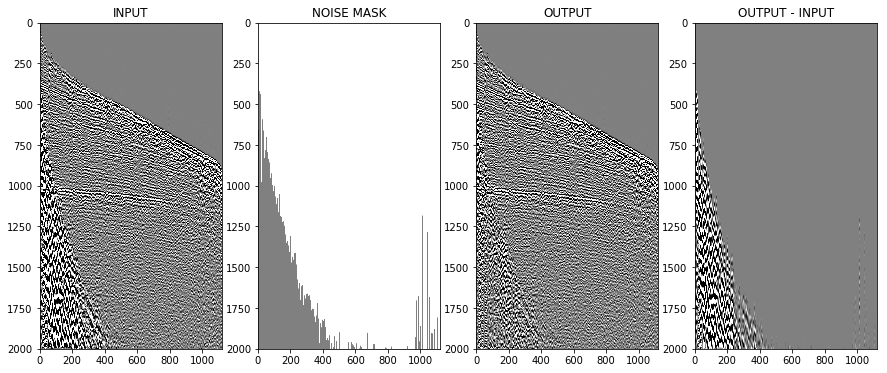

In [43]:
cv = .5
seismic_plot([raw, att_sigm, out, out-raw],
             names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

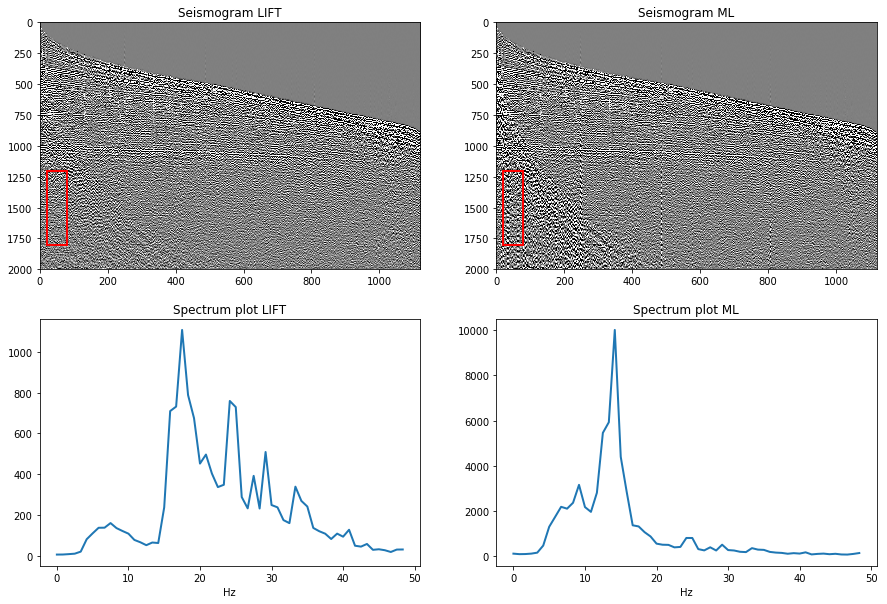

In [48]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(20, 80), slice(1200, 1800)),
                    rate=0.002, max_freq=49,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

In [49]:
i = 30
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1, shuffle=False)
             .load(components=('raw', 'lift'), fmt='segy',
                   tslice=np.arange(2000)))
    
    coef = 5
    x = coef*np.expand_dims(np.vstack(batch.raw), -1)
    y = coef*np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    res = sess.run([attention, predict, lift_trace, attention_sigmoid,
#                     shift_out
                   ],
                    feed_dict={trace_in: x, trace_offset: offset, is_training: False})
    
    x = res[1]
    res = sess.run([attention, predict, lift_trace, attention_sigmoid,
#                     shift_out
                   ],
                    feed_dict={trace_in: x,
#                                trace_offset: offset, 
                               is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)
    
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
# shift_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

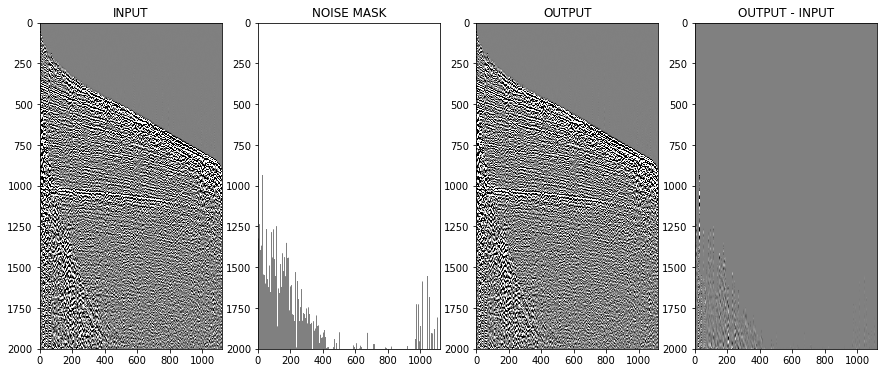

In [50]:
cv = .5
seismic_plot([raw, att_sigm, out, out-raw],
             names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

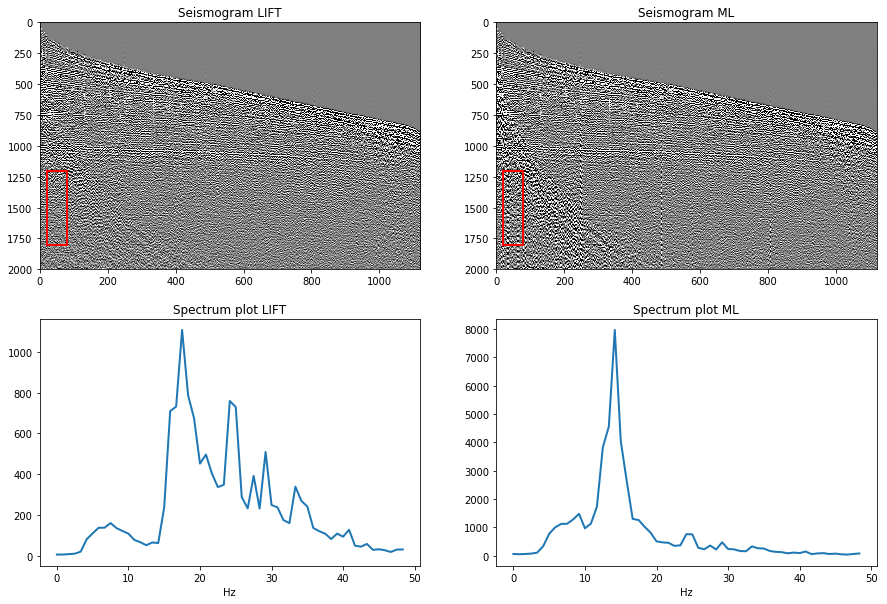

In [51]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(20, 80), slice(1200, 1800)),
                    rate=0.002, max_freq=49,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

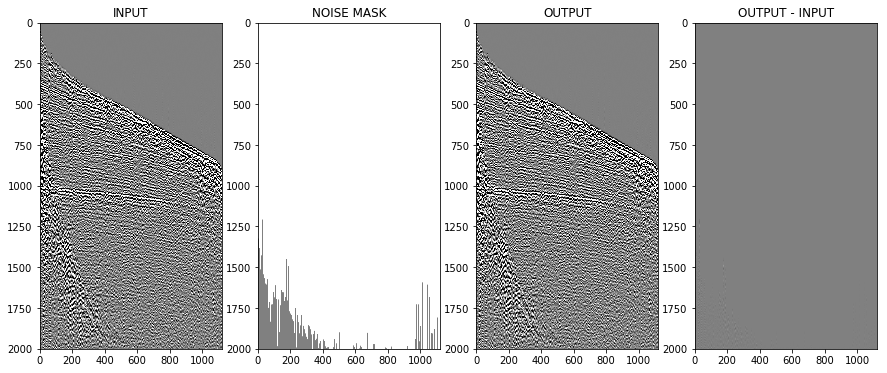

In [53]:
i = 30
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1, shuffle=False)
             .load(components=('raw', 'lift'), fmt='segy',
                   tslice=np.arange(2000)))
    
    coef = 5
    x = coef*np.expand_dims(np.vstack(batch.raw), -1)
    y = coef*np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    res = sess.run([attention, predict, lift_trace, attention_sigmoid,
#                     shift_out
                   ],
                    feed_dict={trace_in: x, trace_offset: offset, is_training: False})
    
    for _ in range(10):
        x = res[1]
        res = sess.run([attention, predict, lift_trace, attention_sigmoid,
    #                     shift_out
                       ],
                        feed_dict={trace_in: x,
    #                                trace_offset: offset, 
                                   is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)
    
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))
# shift_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))
raw = np.squeeze(np.concatenate(x_stack))
lift = np.squeeze(np.concatenate(y_stack))

cv = .5
seismic_plot([raw, att_sigm, out, out-raw],
             names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

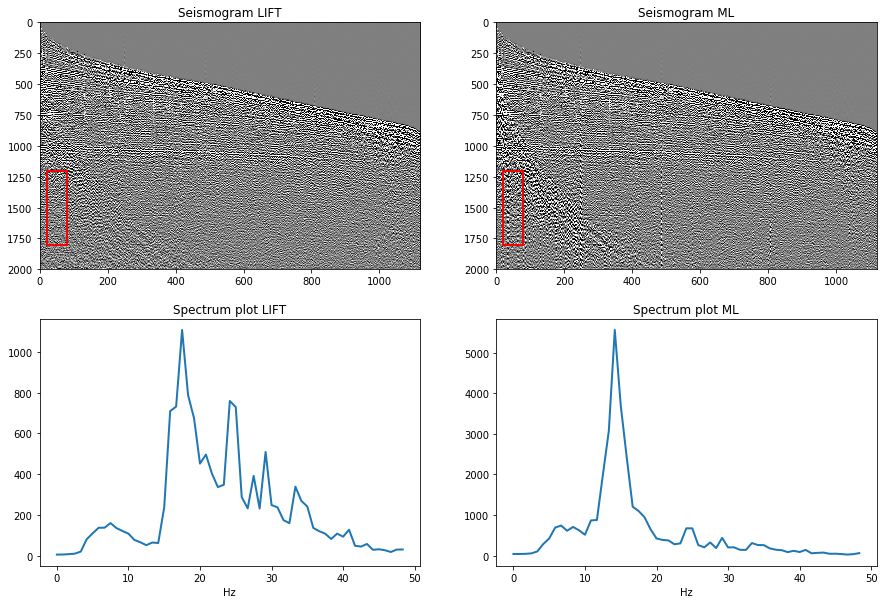

In [54]:
spectrum_plot([lift, out], names=['LIFT', 'ML'],
             frame=(slice(20, 80), slice(1200, 1800)),
                    rate=0.002, max_freq=49,
                    figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

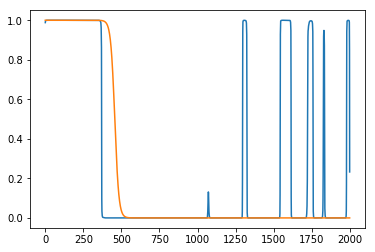

<Figure size 720x288 with 0 Axes>

In [114]:
i = 8
plt.plot(att[i])
plt.plot(att_sigm[i])
plt.figure(figsize=(10, 4))
# plt.plot(raw[i])
# plt.plot(out[i])
plt.show()

In [185]:
# saver.save(sess, "./attention_model_dataset_2.ckpt") #set correct path where to save the model

'./attention_model_dataset_2.ckpt'

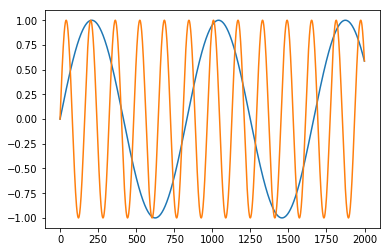

In [249]:
waves = np.array([np.sin(np.linspace(0, 2 * np.pi * 4 * k, 2000)) for k in np.arange(0.1, 100, 0.1)])
f_wave = np.arange(0.1, 100, 0.1)
plt.plot(waves[5])
plt.plot(waves[30])
plt.show()

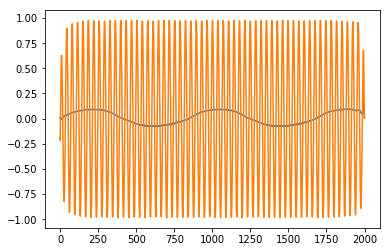

In [250]:
res = sess.run(lift_trace,
               feed_dict={trace_in: waves.reshape((-1, 2000, 1)),
                          trace_offset: np.array([0] * len(waves)).reshape((-1, 1)),
                          is_training: False})

plt.plot(np.squeeze(res[5]))
plt.plot(np.squeeze(res[140]))
plt.show()

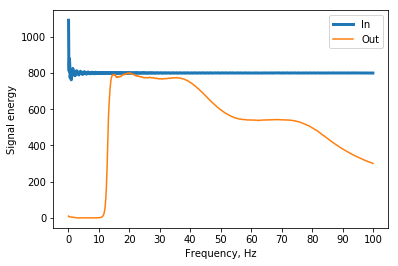

In [251]:
plt.plot(f_wave, np.sum(waves[:, 200: 1800] ** 2, axis=1), label='In', lw=3)
plt.plot(f_wave, np.sum(res[:, 200: 1800] ** 2, axis=1), label='Out')
plt.xlabel('Frequency, Hz')
plt.ylabel('Signal energy')
plt.xticks(np.arange(0, 101, 10))
plt.legend()
plt.show()

In [252]:
spec_res = abs(np.fft.rfft(res[:, 500:2500, 0], axis=1))**2
freqs = np.fft.rfftfreq(len(waves[0, 500:2500]), d=0.002)

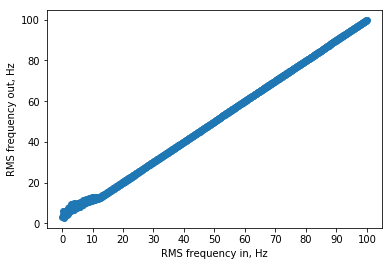

In [242]:
plt.scatter(f_wave,
            np.sqrt(np.sum(freqs**2 * spec_res, axis=1) / np.sum(spec_res, axis=1)))
plt.xlabel('RMS frequency in, Hz')
plt.ylabel('RMS frequency out, Hz')
plt.xticks(np.arange(0, 101, 10))
plt.show()

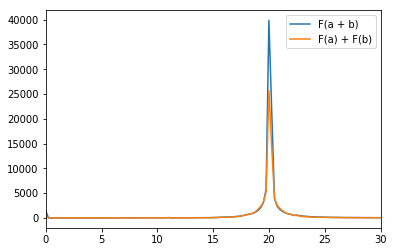

In [172]:
a = 200 # 7Hz
b = 200 # 8Hz

freqs = np.fft.rfftfreq(len(waves[a]), d=0.002)
# plt.plot(freqs, abs(np.fft.rfft(waves[a] + waves[b]))**2, label='a + b')

res = sess.run(lift_trace,
               feed_dict={trace_in: (waves[a] + waves[b]).reshape((-1, 2000, 1)),
                          trace_offset: np.array([0]).reshape((-1, 1)),
                          is_training: False})
plt.plot(freqs, abs(np.fft.rfft(res[0], axis=0))**2, label=('F(a + b)'))

res_a = sess.run(lift_trace,
                feed_dict={trace_in: (waves[a]).reshape((-1, 2000, 1)),
                           trace_offset: np.array([0]).reshape((-1, 1)), 
                           is_training: False})

res_b = sess.run(lift_trace,
                  feed_dict={trace_in: (waves[b]).reshape((-1, 2000, 1)),
                             trace_offset: np.array([0]).reshape((-1, 1)),
                             is_training: False})

plt.plot(freqs, abs(np.fft.rfft(res_a[0], axis=0))**2 + abs(np.fft.rfft(res_b[0], axis=0))**2,
        label="F(a) + F(b)")
plt.xlim([0, 30])
plt.legend()
plt.show()

In [174]:
abs(x).mean()

0.043595105

In [409]:
from seismicpro.src import write_segy_file, merge_segy_files

In [209]:
batch.meta['raw']['samples']

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 5.978e+03, 5.980e+03,
       5.982e+03])

In [411]:
import segyio

write_set = Dataset(TraceIndex(index), SeismicBatch)

batch_size = 2000

for k in range(1 + len(write_set) // batch_size):
    batch = (write_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', ), fmt='segy', tslice=np.arange(2000)))
    
    x = np.expand_dims(np.vstack(batch.raw), -1)
    res = sess.run([predict], feed_dict={trace_in: x, is_training: False})
    
    df = batch.index.get_df(reset=False)
    sort_by = batch.meta['raw']['sorting']
    if sort_by is not None:
        df = df.sort_values(by=sort_by)

    df = df.loc[batch.indices]
    df.reset_index(drop=batch.index.name is None, inplace=True)
    headers = list(set(df.columns.levels[0]))
    segy_headers = [h for h in headers if hasattr(segyio.TraceField, h)]
    df = df[segy_headers]
    df.columns = df.columns.droplevel(1)
    write_segy_file(res[0], df, batch.meta['raw']['samples'],
                   './orech_dumps/' + str(k) + '.sgy')

In [243]:
merge_segy_files(path=os.path.join('./orech_dumps/', '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

In [274]:
from seismicpro.src import SegyFilesIndex

In [277]:
SegyFilesIndex(name='raw', extra_headers=['offset'],
           path='./dumps/*.sgy').head()

,FieldRecord,offset,TraceNumber,TRACE_SEQUENCE_FILE
,,,,raw
"(file_id, raw)",,,,
./dumps/0.sgy,111906,35,1656,1
./dumps/0.sgy,111906,36,1657,2
./dumps/0.sgy,111906,78,1655,3
./dumps/0.sgy,111906,79,1658,4
./dumps/0.sgy,111906,127,1654,5


In [306]:
windex = FieldIndex(name='raw', extra_headers=['offset'],
                    path='/notebooks/egor/geolog/notebooks/merged.sgy'
#                     path=path_raw
                   )
windex.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
111906,35,1656,1,/notebooks/egor/geolog/notebooks/merged.sgy
111906,3319,3126,2298,/notebooks/egor/geolog/notebooks/merged.sgy
111906,3320,848,2299,/notebooks/egor/geolog/notebooks/merged.sgy
111906,3320,2436,2300,/notebooks/egor/geolog/notebooks/merged.sgy
111906,3322,189,2301,/notebooks/egor/geolog/notebooks/merged.sgy


In [307]:
tbatch = (Dataset(index, SeismicBatch).next_batch(10)
         .load(components=('raw', ), fmt='segy', tslice=np.arange(2992))
#          .sort_traces(src='raw', dst='raw', sort_by='TraceNumber')
         .sort_traces(src='raw', dst='raw', sort_by=('TRACE_SEQUENCE_FILE', 'raw'))
         )

In [310]:
wbatch = (Dataset(windex, SeismicBatch).next_batch(10)
         .load(components=('raw', ), fmt='segy')
#          .sort_traces(src='raw', dst='raw', sort_by='TraceNumber')
          .sort_traces(src='raw', dst='raw', sort_by=('TRACE_SEQUENCE_FILE', 'raw'))
         )

In [305]:
# windex.head()

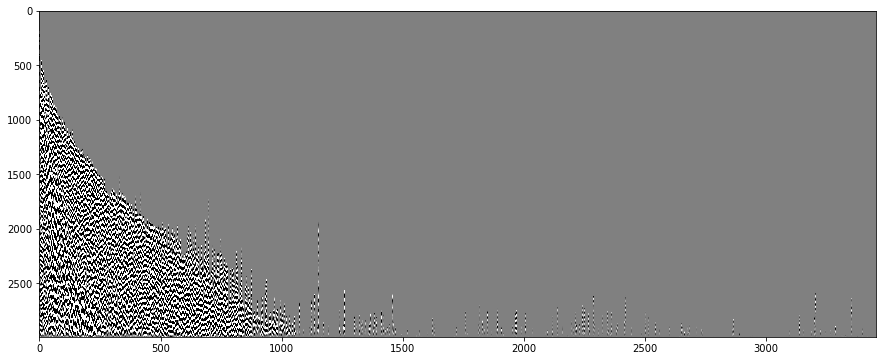

In [312]:
seismic_plot(tbatch.raw[2] - wbatch.raw[2],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

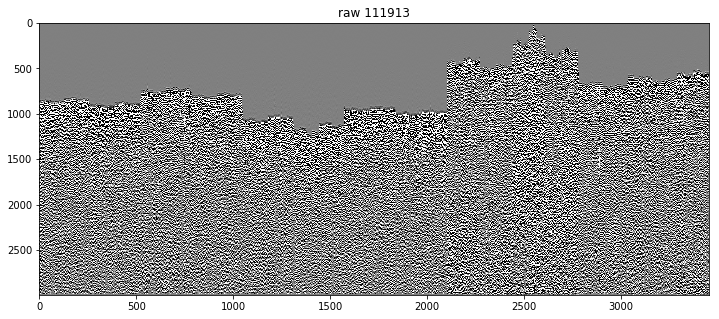

In [261]:
cv = 0.1
wbatch.seismic_plot('raw', tbatch.indices[7],
                   figsize=(12, 5), vmin=-cv, vmax=cv, cmap='gray')